<a href="https://colab.research.google.com/github/hendra136/Business_intellegence/blob/main/Assigmeny_Day_32_Uplift_Modeling_and_Meta_Learner_Strategies_in_Business_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install causalml
!pip install scikit-plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

import scikitplot as skplt

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from causalml.inference.meta import BaseSClassifier
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
import causalml.metrics as metrics
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from IPython.display import Image

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 25
sns.set()

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (3).csv


In [ ]:
# Membaca dataset menjadi dataframe
df = pd.read_csv('data.csv')

In [ ]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
df.select_dtypes(include=int).corr()

,recency,used_discount,used_bogo,is_referral,conversion
recency,1.000000,-0.031336,-0.026617,-0.052106,-0.074765
used_discount,-0.031336,1.000000,-0.816943,0.020900,0.006712
used_bogo,-0.026617,-0.816943,1.000000,0.021346,0.051999
is_referral,-0.052106,0.020900,0.021346,1.000000,-0.073924
conversion,-0.074765,0.006712,0.051999,-0.073924,1.000000


In [ ]:
# Get the size of the dataset
df.shape

(64000, 9)

In [ ]:
# Get list of columns and their data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [ ]:
# Get summary statistics of the dataset
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Data Quality: Jumlah Missing Values per Kolom
df.isnull().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
offer            0
conversion       0
dtype: int64

In [ ]:
# Tipe Data dari Setiap Kolom
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
offer             object
conversion         int64
dtype: object

# EDA

### Initialize variable

In [ ]:
# Goals : impact email Women vs Men terhadap visit

# menetapkan variabel

# variabel treatment
var_treat = 'offer'

# target variabel
var_target = 'conversion'

# kategori kontrol/acuan -> tidak dikasih treatment atau treatment = 0
cat_control = 'No Offer'

# kategori treatment -> dikasih treatment, treatment = 1
cat_treat = 'Discount'

# kategori yang dikecualikan
cat_exclude = 'Buy One Get One'

# col to drop
var_to_drop = ['is_referral', 'used_discount','used_bogo']

# col to encode
cat_cols = ['zip_code', 'channel']

In [ ]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


### Remove category if any segment need to be exclude

In [ ]:
if cat_exclude != None:
  df = df.loc[df[var_treat] != cat_exclude].reset_index(drop=True)

In [ ]:
df.offer.value_counts()

offer
Discount    21307
No Offer    21306
Name: count, dtype: int64

In [ ]:
df[var_treat].nunique()

2

In [ ]:
n_treatment = df[var_treat].nunique()

In [ ]:
n_treatment

2

## Train-Test Split Data

In [ ]:
X_train, X_test = train_test_split(
    df.drop(var_to_drop, axis = 1),
    test_size = 0.5,
    random_state = 1000
)

## Visualisasi

<Axes: xlabel='offer', ylabel='count'>

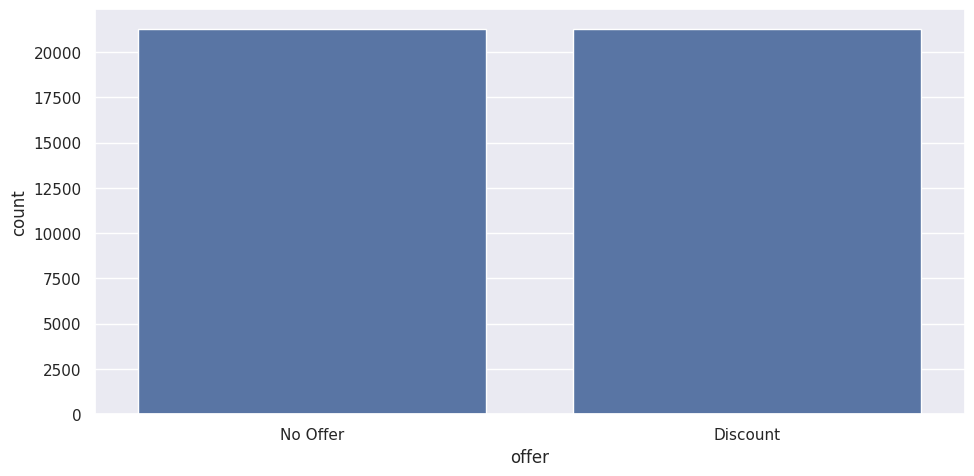

In [ ]:
# 1. Visualisasi Distribusi Variabel Target
sns.countplot(data=df, x = var_treat)

In [ ]:
df = df.loc[df[var_treat] != 'Buy One Get One'].reset_index(drop=True)

In [ ]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,6,329.08,1,1,Rural,1,Web,No Offer,0
1,9,675.83,1,0,Rural,1,Web,Discount,0
2,9,675.07,1,1,Rural,1,Phone,Discount,0
3,2,101.64,0,1,Urban,0,Web,Discount,1
4,4,241.42,0,1,Rural,1,Multichannel,No Offer,0


In [ ]:
df.offer.value_counts()

offer
Discount    21307
No Offer    21306
Name: count, dtype: int64

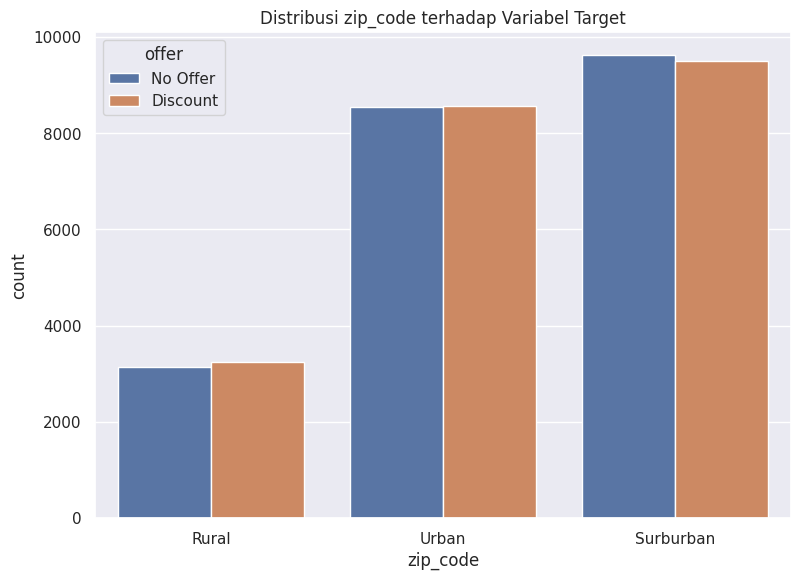

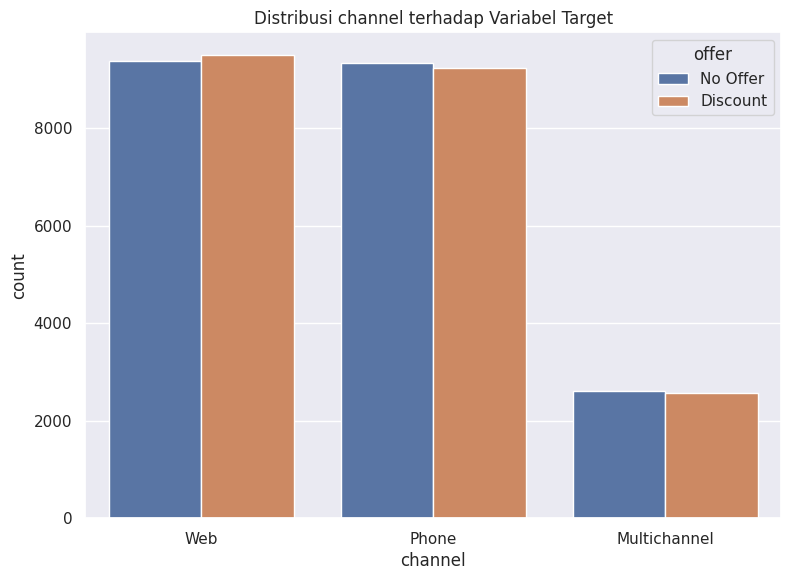

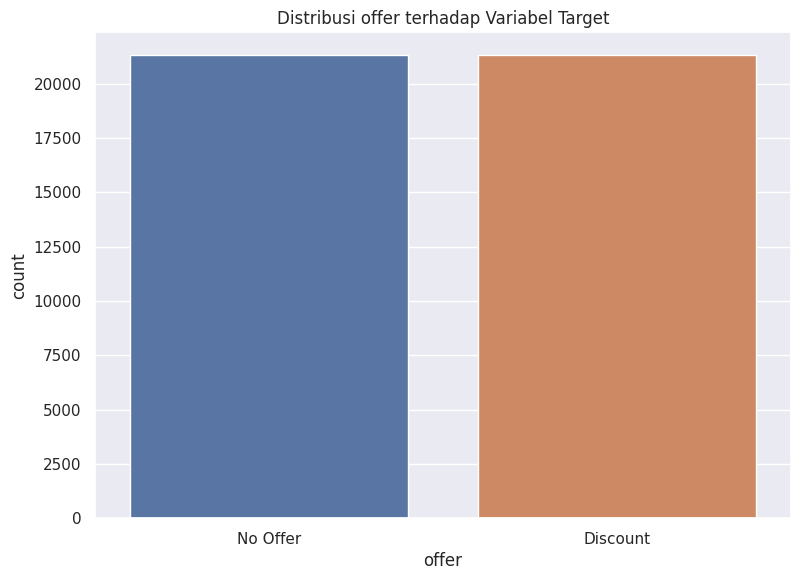

In [ ]:
# 2. Visualisasi Distribusi Variabel Kategorikal terhadap Variabel Target
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='offer', data=df)
    plt.title(f'Distribusi {col} terhadap Variabel Target')
    plt.show()


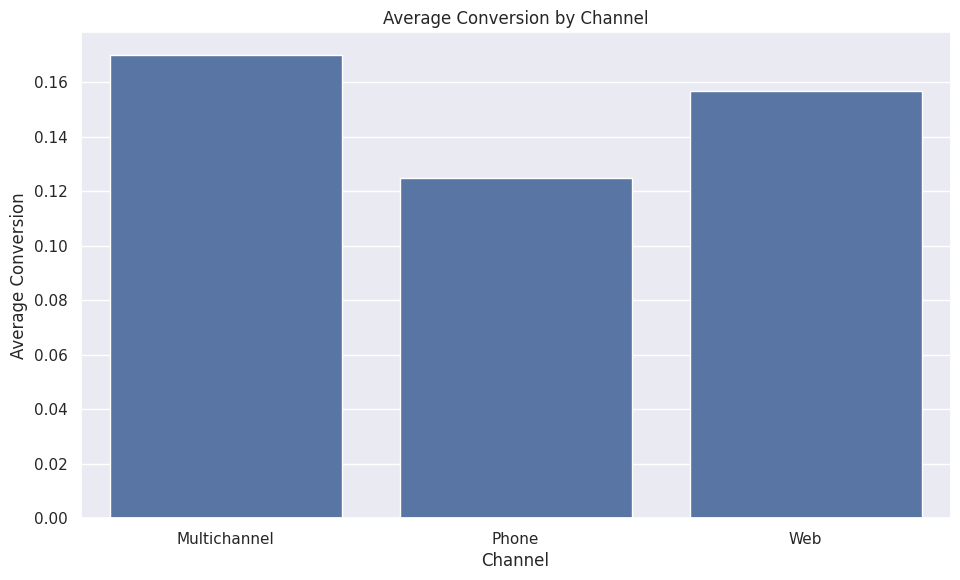

In [ ]:
# 3. Bar plot: Average conversion by channel
avg_conversion_by_channel = df.groupby('channel')['conversion'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='channel', y='conversion', data=avg_conversion_by_channel)
plt.title('Average Conversion by Channel')
plt.xlabel('Channel')
plt.ylabel('Average Conversion')
plt.show()

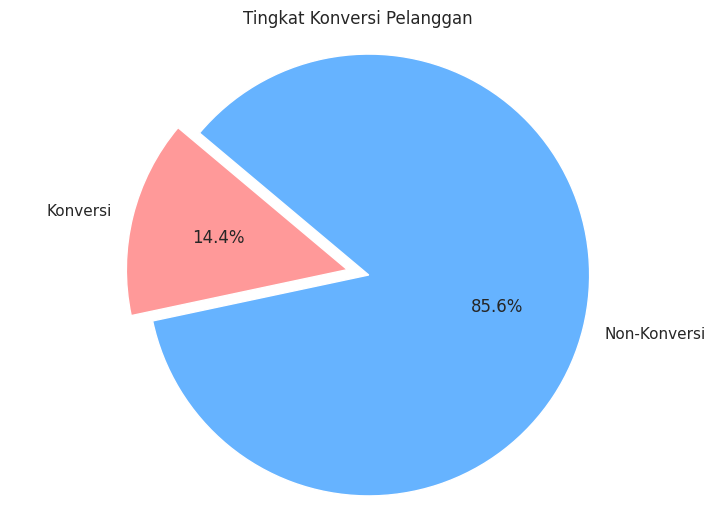

In [ ]:
# 4. Membuat diagram batang

# Menghitung jumlah pelanggan yang konversi dan yang tidak konversi
konversi = df['conversion'].sum()
non_konversi = len(df) - konversi

# Membuat pie chart
labels = ['Konversi', 'Non-Konversi']
sizes = [konversi, non_konversi]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode 1st slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Tingkat Konversi Pelanggan')
plt.axis('equal')
plt.show()


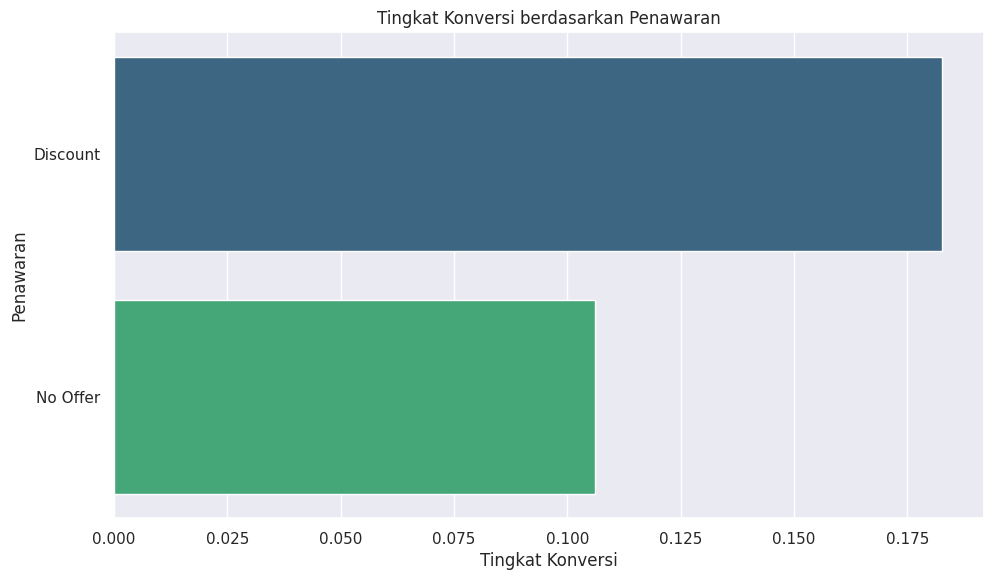

In [ ]:
# 5. Menampilkan konversi pelanggan berdasarkan offer

# Menghitung tingkat konversi berdasarkan penawaran (offer)
conversion_by_offer = df.groupby('offer')['conversion'].mean().reset_index()

# Membuat diagram batang horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x='conversion', y='offer', data=conversion_by_offer, palette='viridis')
plt.title('Tingkat Konversi berdasarkan Penawaran')
plt.xlabel('Tingkat Konversi')
plt.ylabel('Penawaran')
plt.show()


<Axes: xlabel='offer', ylabel='conversion'>

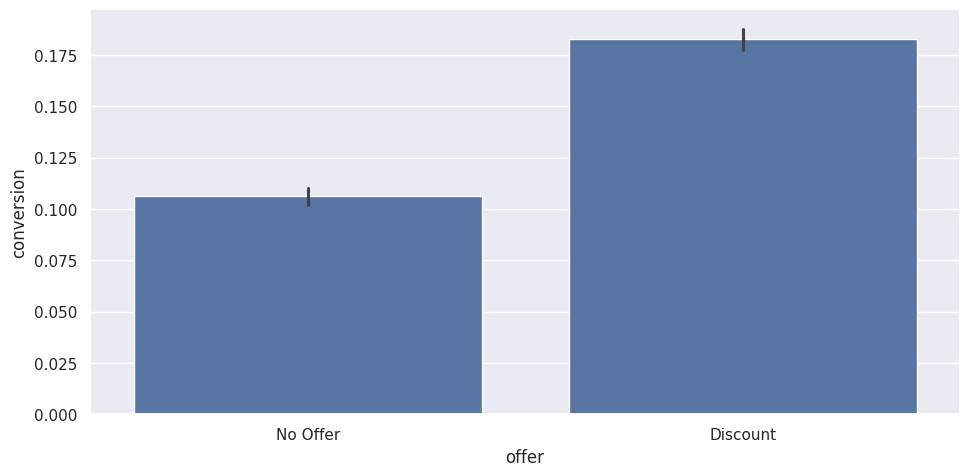

In [ ]:
# visualisasi hubungan offer dan conversion
sns.barplot(x = 'offer',
            y = 'conversion',
            data = df)

# Data Preprocessing

In [ ]:
X_train.head()

,recency,history,zip_code,channel,offer,conversion
25807,3,383.94,Rural,Web,No Offer,0
35060,1,263.16,Urban,Web,No Offer,0
42391,6,194.72,Urban,Phone,Discount,0
6352,11,66.96,Surburban,Web,No Offer,0
18376,5,640.16,Urban,Multichannel,Discount,0


In [ ]:
X_test.head()

,recency,history,zip_code,channel,offer,conversion
2930,6,353.32,Surburban,Multichannel,No Offer,0
7931,10,60.06,Urban,Web,No Offer,0
26143,12,151.73,Rural,Web,Discount,0
33666,9,29.99,Rural,Phone,Discount,0
13268,5,672.56,Urban,Phone,No Offer,1


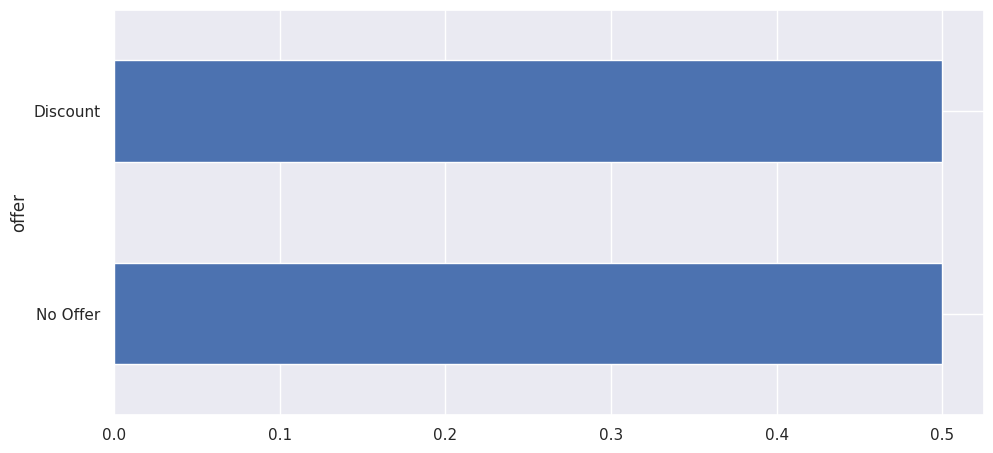

In [ ]:
X_train.offer.value_counts(normalize = True).plot.barh();

In [ ]:
# Encode categorical variables on X train data
dummies = pd.get_dummies(X_train[cat_cols], drop_first=True)
X_train = pd.concat([X_train.drop(cat_cols, axis=1), dummies], axis=1)

# Encode categorical variables on X test data
dummies = pd.get_dummies(X_test[cat_cols], drop_first=True)
X_test = pd.concat([X_test.drop(cat_cols, axis=1), dummies], axis=1)

In [ ]:
is_treat = X_train[X_train.offer != cat_control]
not_treat = X_train[X_train.offer == cat_control]

In [ ]:
cat_control

'No Offer'

In [ ]:
cat_treat

'Discount'

In [ ]:
not_treat.head()

,recency,history,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
25807,3,383.94,No Offer,0,False,False,False,True
35060,1,263.16,No Offer,0,False,True,False,True
6352,11,66.96,No Offer,0,True,False,False,True
19446,11,151.21,No Offer,0,False,False,True,False
14285,7,434.17,No Offer,0,True,False,False,True


In [ ]:
is_treat.offer.value_counts()

offer
Discount    10652
Name: count, dtype: int64

In [ ]:
is_treat.head()

,recency,history,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
42391,6,194.72,Discount,0,False,True,True,False
18376,5,640.16,Discount,0,False,True,False,False
10945,1,58.07,Discount,0,False,True,False,True
27203,1,262.07,Discount,0,True,False,False,True
14405,6,91.25,Discount,0,False,True,False,True


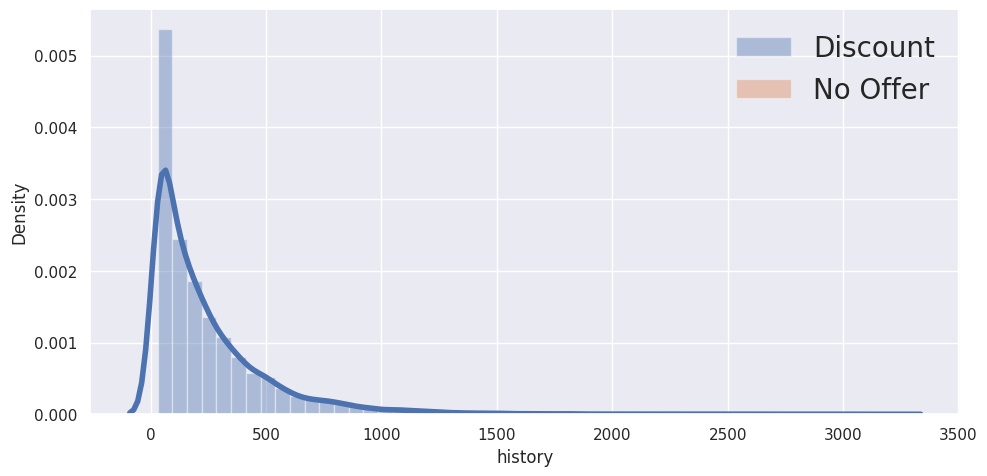

In [ ]:
# bins = 25
sns.distplot(is_treat.query("offer == 'Discount'").history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='Discount')
sns.distplot(is_treat.query("offer == 'No Offer'").history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='No Offer')
# sns.distplot(not_treat.history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

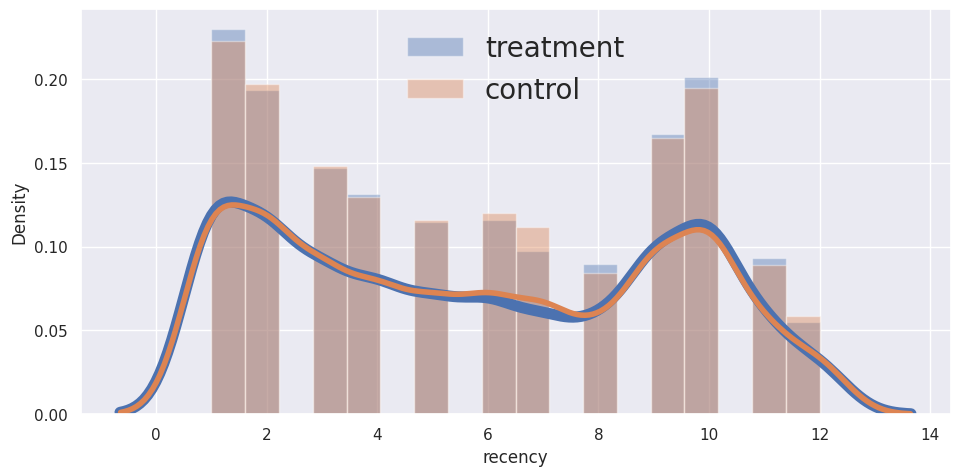

In [ ]:
# bins = 25
sns.distplot(is_treat.recency, hist=True, kde=True, kde_kws={'linewidth': 8}, label='treatment')
sns.distplot(not_treat.recency, hist=True, kde=True, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

# Modeling

In [ ]:
var_target

'conversion'

In [ ]:
var_treat

'offer'

In [ ]:
# Memisahkan prediktor dengan target

x_col = X_train.drop([var_treat, var_target], axis = 1).columns.tolist()
x_col

['recency',
 'history',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Phone',
 'channel_Web']

## S-Leaner

In [ ]:
slearner = BaseSClassifier(LGBMClassifier(), control_name=cat_control)

In [ ]:
slearner

BaseSClassifier(model=LGBMClassifier())

### Estimate Average Treatment Effect

In [ ]:
slearner.estimate_ate(X_train[x_col].values, X_train[var_treat].values, X_train[var_target].values, bootstrap_ci  = True)

[LightGBM] [Info] Number of positive: 3064, number of negative: 18242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 21306, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143809 -> initscore=-1.784005
[LightGBM] [Info] Start training from score -1.784005


array([0.0752797])

## Predict CATE for Each Treatment

In [ ]:
slearner_tau = slearner.predict(X_test[x_col].values, X_test[var_treat].values, X_test[var_target].values)

In [ ]:
slearner_tau

array([[0.09473011],
       [0.04881435],
       [0.04254488],
       ...,
       [0.08781922],
       [0.06279355],
       [0.08206634]])

### Insert result to dataframe

In [ ]:
X_test['s_learner_tau'] = slearner_tau

In [ ]:
X_test

,recency,history,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,s_learner_tau
2930,6,353.32,No Offer,0,True,False,False,False,0.094730
7931,10,60.06,No Offer,0,False,True,False,True,0.048814
26143,12,151.73,Discount,0,False,False,False,True,0.042545
33666,9,29.99,Discount,0,False,False,True,False,0.036569
13268,5,672.56,No Offer,1,False,True,True,False,0.162815
...,...,...,...,...,...,...,...,...,...
22530,7,150.66,Discount,0,True,False,True,False,0.021285
15777,1,29.99,Discount,0,True,False,False,True,0.013997
11304,9,51.58,No Offer,0,True,False,False,True,0.087819
30656,7,56.26,No Offer,0,False,True,True,False,0.062794


### Check uplift distribution

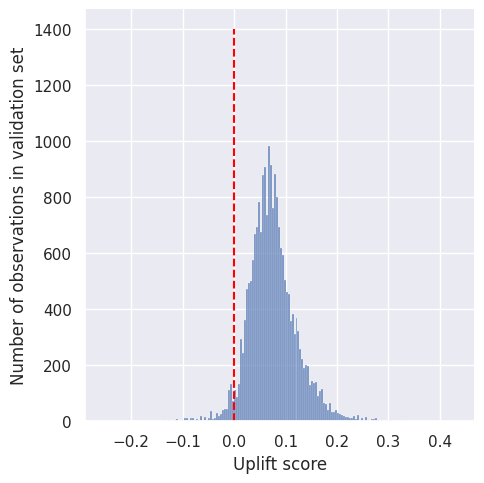

In [ ]:
sns.displot(data = X_test['s_learner_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

The uplift score describes how much an input context is expected to benefit from a treatment, in terms of the response variable. The higher the score, the greater the treatment is expected to benefit the individual associated with the context. The score is used to prioritize treatment assignment

# Uplift-Tree Based (Uplift Random Forest)

Define uplift random forest classifier

In [ ]:
uplift_model = UpliftRandomForestClassifier(control_name=cat_control, random_state=1000)

In [ ]:
uplift_model.fit(
    X_train[x_col].values,
    treatment = X_train[var_treat].values,
    y = X_train[var_target].values
)

Do prediction with trained model

In [ ]:
y_pred = uplift_model.predict(X_test[x_col].values, full_output=True)

Check the first 5 rows

In [ ]:
y_pred.head()

,No Offer,Discount,recommended_treatment,delta_Discount,max_delta
0,0.106741,0.192376,1,0.085635,0.085635
1,0.075931,0.153588,1,0.077657,0.077657
2,0.101378,0.169272,1,0.067894,0.067894
3,0.084705,0.144885,1,0.060180,0.060180
4,0.112321,0.213719,1,0.101398,0.101398


In [ ]:
X_test['uplift_forest_tau'] = uplift_model.predict(X_test[x_col].values, full_output=False)

In [ ]:
X_test.head()

,recency,history,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,s_learner_tau,uplift_forest_tau
2930,6,353.32,No Offer,0,True,False,False,False,0.094730,0.085635
7931,10,60.06,No Offer,0,False,True,False,True,0.048814,0.077657
26143,12,151.73,Discount,0,False,False,False,True,0.042545,0.067894
33666,9,29.99,Discount,0,False,False,True,False,0.036569,0.060180
13268,5,672.56,No Offer,1,False,True,True,False,0.162815,0.101398


Check uplift distribution

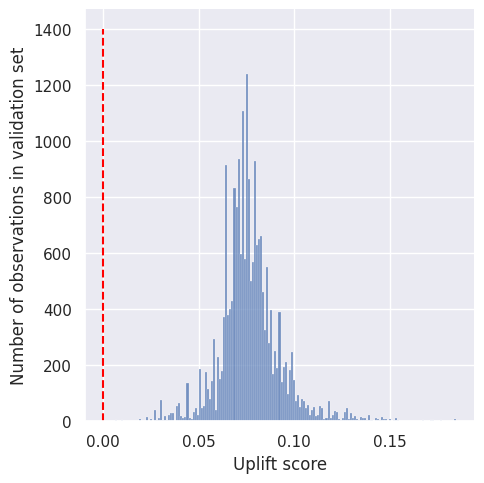

In [ ]:
sns.displot(data = X_test['uplift_forest_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

# Model Evaluation

In [ ]:
def auuc_metric_maker(dataframe, tau_outcome_var, cat_control, cat_treat):

  treatment_category_result = X_test[[tau_outcome_var]].reset_index(drop=True)
  treatment_category_result.columns = [cat_treat]

  # If all deltas are negative, assing to control; otherwise assign to the treatment
  # with the highest delta
  best_treatment = np.where(
      (treatment_category_result < 0).all(axis=1),
      cat_control,
      treatment_category_result.idxmax(axis=1)
  )
  # Create indicator variables for whether a unit happened to have the
  # recommended treatment or was in the control group
  actual_is_best = np.where(dataframe[var_treat] == best_treatment, 1, 0)
  actual_is_control = np.where(dataframe[var_treat] == cat_control, 1, 0)

  synthetic = (actual_is_best == 1) | (actual_is_control == 1)
  synth = treatment_category_result[synthetic]

  auuc_score = (synth.assign(
      is_treated = 1 - actual_is_control[synthetic],
      conversion = dataframe.loc[synthetic, var_target].values,
      model_result = synth.max(axis=1)
  ).drop(columns=list([cat_treat]))).rename(columns = {"model_result": tau_outcome_var})

  return auuc_score

## S-Learner Evaluation

In [ ]:
slearner_auuc_score = auuc_metric_maker(X_test, tau_outcome_var = "s_learner_tau", cat_control = cat_control, cat_treat = cat_treat)

In [ ]:
slearner_auuc_score.head()

,is_treated,conversion,s_learner_tau
0,0,0,0.094730
1,0,0,0.048814
2,1,0,0.042545
3,1,0,0.036569
4,0,1,0.162815


Calculate treated group based who visit our platform, treated or not

In [ ]:
slearner_auuc_score.groupby('is_treated').sum()[[var_target]]

,conversion
is_treated,
0,1144
1,1881


## Evaluation Uplift Forest

In [ ]:
uplift_forest_auuc_score = auuc_metric_maker(X_test, tau_outcome_var = "uplift_forest_tau", cat_control = cat_control, cat_treat = cat_treat)

In [ ]:
uplift_forest_auuc_score.head()

,is_treated,conversion,uplift_forest_tau
0,0,0,0.085635
1,0,0,0.077657
2,1,0,0.067894
3,1,0,0.060180
4,0,1,0.101398


In [ ]:
uplift_forest_auuc_score.groupby('is_treated').sum()[[var_target]]

,conversion
is_treated,
0,1144
1,1948


## S-Learner Model

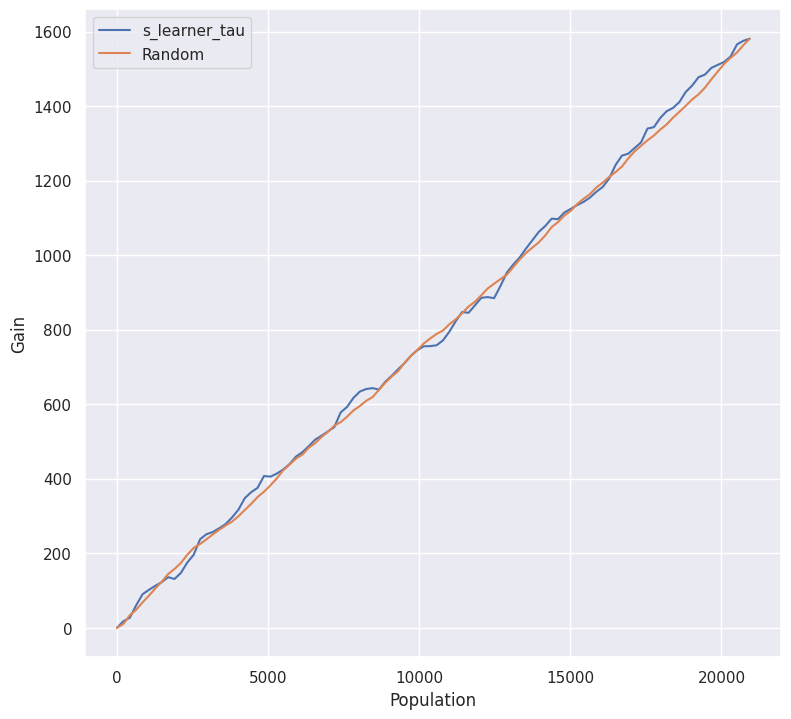

In [ ]:
metrics.plot_gain(slearner_auuc_score, outcome_col=var_target, treatment_col='is_treated')

## Uplift Forest Model

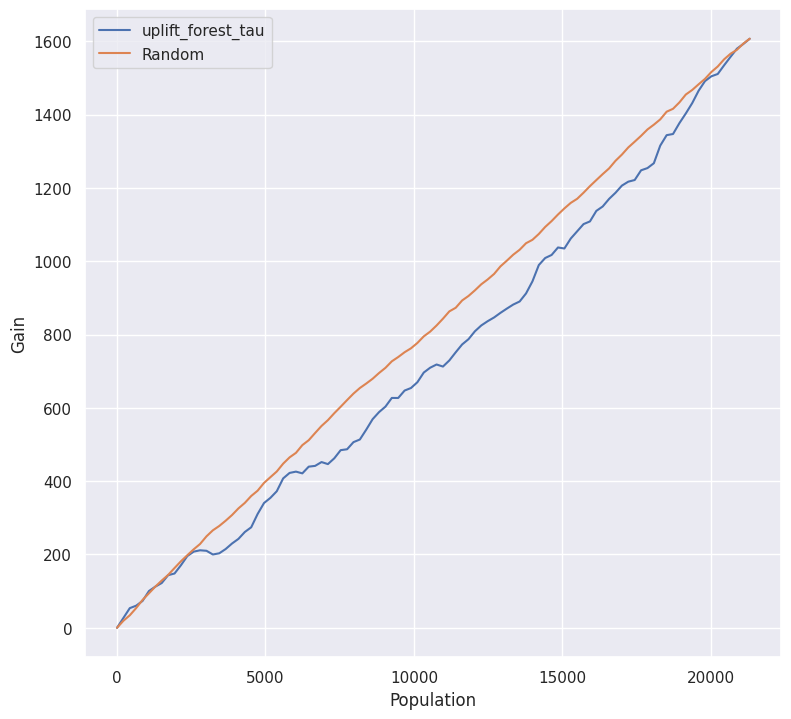

In [ ]:
metrics.plot_gain(uplift_forest_auuc_score, outcome_col=var_target, treatment_col='is_treated')

## AUUC and Qini Score

AUUC for S-Learner

In [ ]:
metrics.auuc_score(slearner_auuc_score, outcome_col=var_target, treatment_col='is_treated')

s_learner_tau    0.500170
Random           0.495053
dtype: float64

AUUC for Uplift Forest

In [ ]:
metrics.auuc_score(uplift_forest_auuc_score, outcome_col=var_target, treatment_col='is_treated')

uplift_forest_tau    0.462301
Random               0.509135
dtype: float64

Qini Score for S-Learner

In [ ]:
metrics.qini_score(slearner_auuc_score, outcome_col=var_target, treatment_col='is_treated')

s_learner_tau    0.017618
Random           0.000000
dtype: float64

Qini Score for Uplift Forest

In [ ]:
metrics.qini_score(uplift_forest_auuc_score, outcome_col=var_target, treatment_col='is_treated')

uplift_forest_tau   -0.046078
Random               0.000000
dtype: float64

If the model is working well, we should see a larger positive difference in the highest decile, decreasing to a small or negative difference in the lowest decile (i.e. treatment rate similar to control rate, or lower than control rate). In other words, as predicted uplift increases, the true uplift from control to treatment group should increase as well.

Create new dataframe object

In [ ]:
X_test

,recency,history,offer,conversion,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,s_learner_tau,uplift_forest_tau
2930,6,353.32,No Offer,0,True,False,False,False,0.094730,0.085635
7931,10,60.06,No Offer,0,False,True,False,True,0.048814,0.077657
26143,12,151.73,Discount,0,False,False,False,True,0.042545,0.067894
33666,9,29.99,Discount,0,False,False,True,False,0.036569,0.060180
13268,5,672.56,No Offer,1,False,True,True,False,0.162815,0.101398
...,...,...,...,...,...,...,...,...,...,...
22530,7,150.66,Discount,0,True,False,True,False,0.021285,0.087311
15777,1,29.99,Discount,0,True,False,False,True,0.013997,0.055071
11304,9,51.58,No Offer,0,True,False,False,True,0.087819,0.070897
30656,7,56.26,No Offer,0,False,True,True,False,0.062794,0.083287


In [ ]:
def quantile_and_treatment(dataframe, tau_outcome_var, var_treat, cat_control, cat_treat):
  # Bin uplift score by using quantile
  score_quantiles, score_quantile_bins = pd.qcut(
    x = dataframe[tau_outcome_var],
    q = 10,
    retbins = True,
    duplicates = 'drop'
  )
  dataframe['Quantile bin'] = score_quantiles
  # Calculate number of samples for each bins
  count_by_quantile_and_treatment = dataframe.groupby(['Quantile bin', var_treat])[var_treat].count().unstack(-1)
  return count_by_quantile_and_treatment[[cat_control, cat_treat]]

In [ ]:
final_result = quantile_and_treatment(X_test, tau_outcome_var = "uplift_forest_tau", var_treat = var_treat, cat_control = cat_control, cat_treat = cat_treat)

Visualize the impact of the treatment

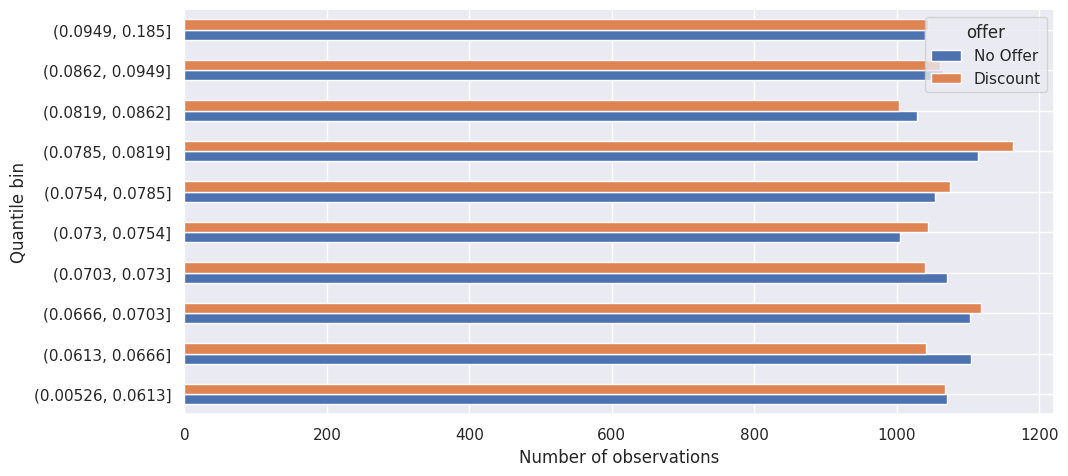

In [ ]:
final_result.plot.barh()
plt.xlabel('Number of observations');

## Uplift Quantile Chart

In [ ]:
def true_uplift(dataframe, tau_outcome_var, var_target, var_treat, cat_treat, ):
  # Bin uplift score by using quantile
  score_quantiles, score_quantile_bins = pd.qcut(
    x = dataframe[tau_outcome_var],
    q = 10,
    retbins = True,
    duplicates = 'drop'
  )

  dataframe['Quantile bin'] = score_quantiles
  # Get the conversion rates within uplift score quantiles for both groups
  validation_treatment_mask = dataframe[var_treat] == cat_treat
  treatment_by_quantile = dataframe[validation_treatment_mask]\
    .groupby('Quantile bin')[var_target].mean()
  control_by_quantile = dataframe[~validation_treatment_mask]\
    .groupby('Quantile bin')[var_target].mean()
  # calculate true uplift
  true_uplift_by_quantile = treatment_by_quantile - control_by_quantile
  return true_uplift_by_quantile

In [ ]:
true_uplift_result = true_uplift(X_test, tau_outcome_var = "uplift_forest_tau", var_target = var_target, var_treat = var_treat, cat_treat = cat_treat)

In [ ]:
true_uplift_result.head(5)

Quantile bin
(0.00526, 0.0613]    0.095007
(0.0613, 0.0666]     0.093143
(0.0666, 0.0703]     0.081530
(0.0703, 0.073]      0.083378
(0.073, 0.0754]      0.063081
Name: conversion, dtype: float64

Visualize uplift quantile chart

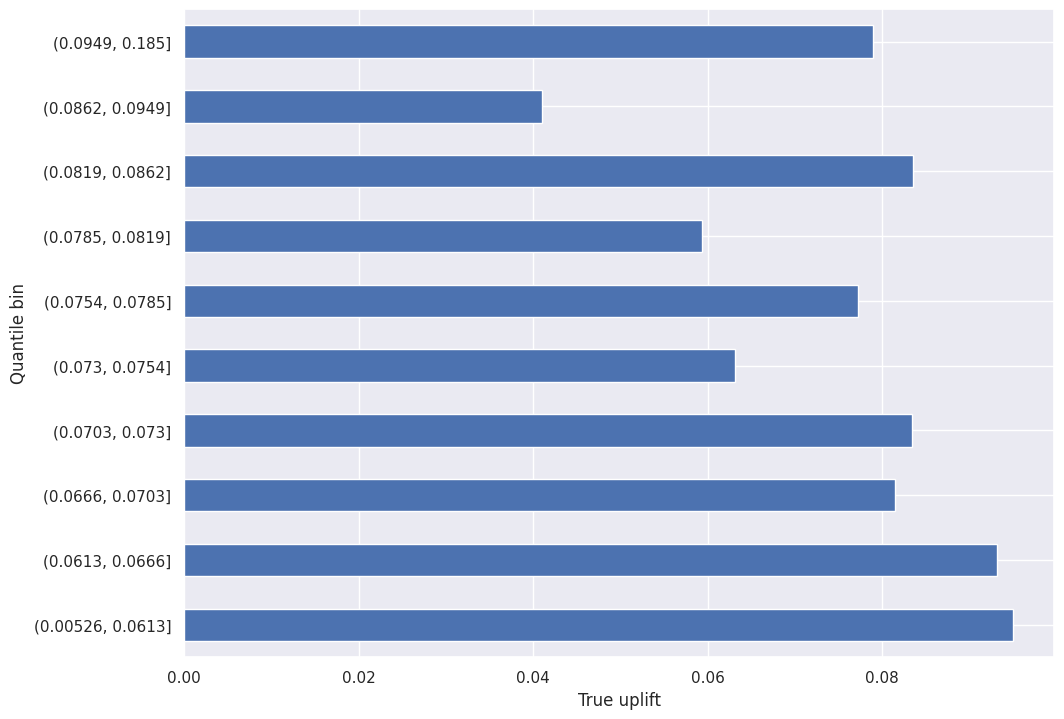

In [ ]:
plt.rcParams["figure.figsize"] = (10, 8)
true_uplift_result.plot.barh()
plt.xlabel('True uplift');

The uplift quantile chart shows that, for the most part, true uplift increases from lower score bins to higher ones, which is what we’d expect to see if the model is working. So it appears our model can effectively segment out customers who more readily respond to treatment.

# Model Interpretation

## Feature Importance (Gain, Permutation, etc)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

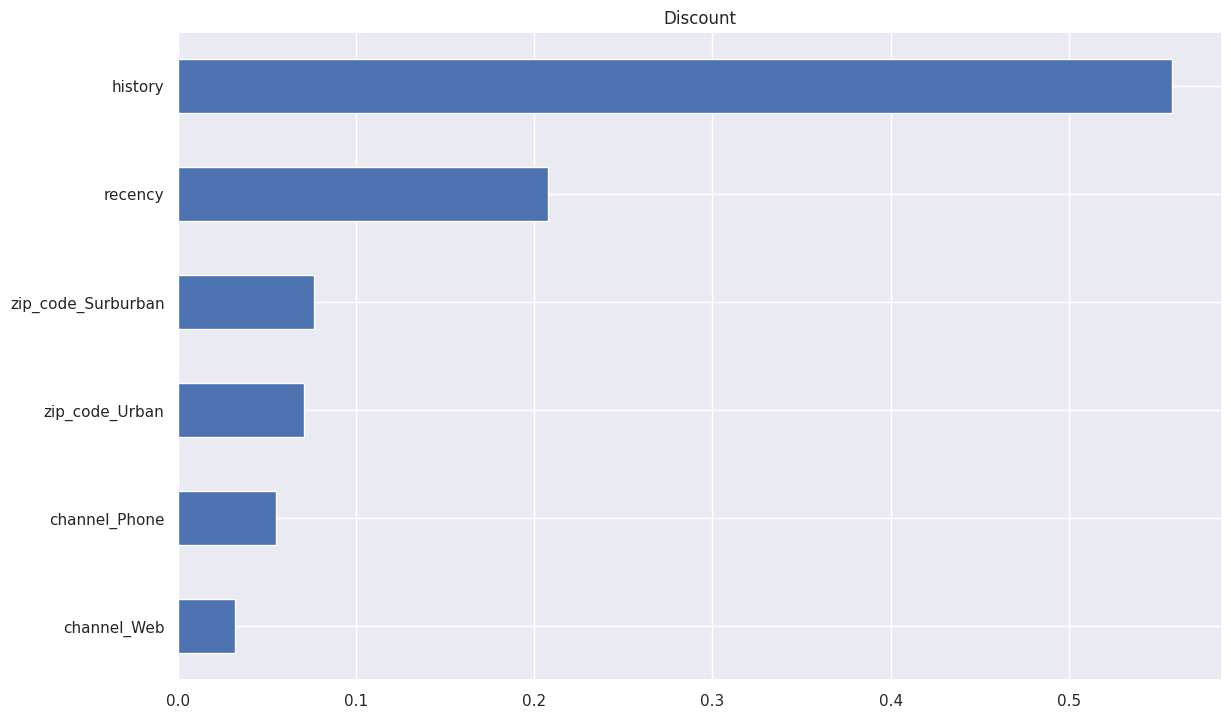

In [ ]:
slearner.plot_importance(X=X_test[x_col],
                        tau=X_test['s_learner_tau'],
                        method='auto',
                        random_state = 42,
                        features=x_col)

## Shapley Dependence Model

Shap Value for History

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

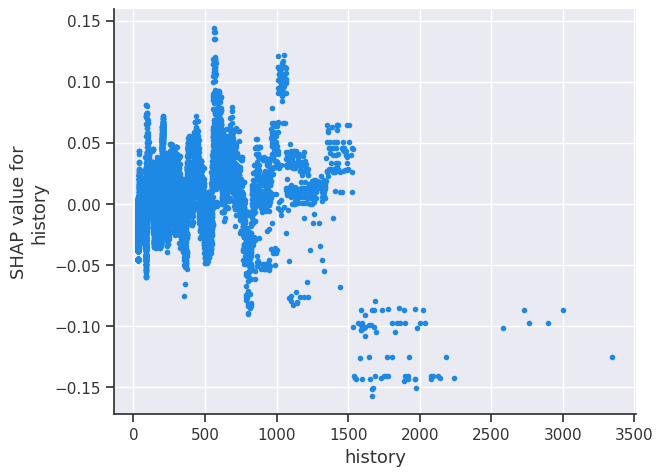

In [ ]:
slearner.plot_shap_dependence(
    treatment_group=cat_treat,
    feature_idx='history',
    X=X_test[x_col].values,
    features = x_col,
    tau= X_test['s_learner_tau'],
    interaction_idx=None
)

### Shap Value for used discount

### Shap Value for used_bogo

### Shap Value for Recency

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

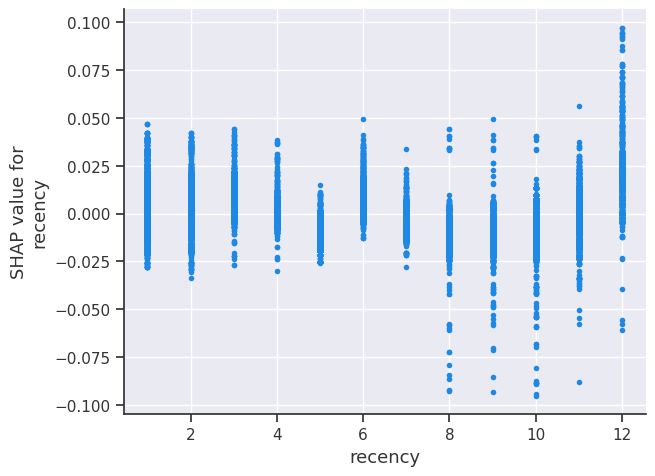

In [ ]:
slearner.plot_shap_dependence(
    treatment_group=cat_treat,
    feature_idx='recency',
    X=X_test[x_col].values,
    features = x_col,
    tau= X_test['s_learner_tau'],
    interaction_idx=None
)

# Special Explanation Method for Tree-Based Model

## Feature Importance

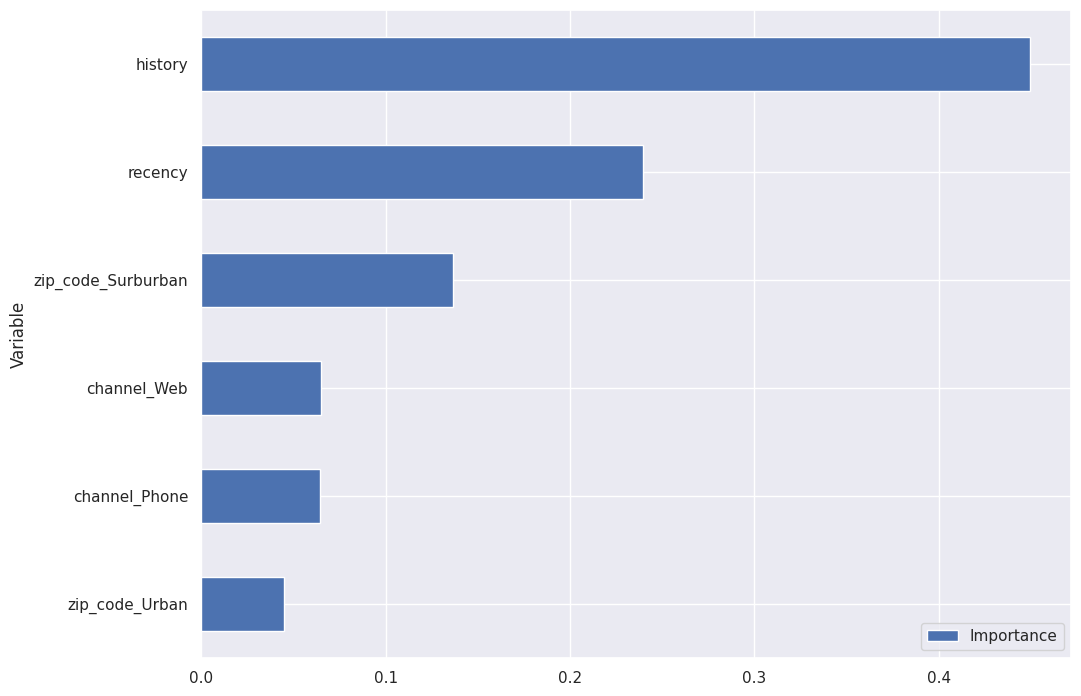

In [ ]:
pd.DataFrame(
    {
        "Variable": x_col,
        "Importance": uplift_model.feature_importances_
    }
).sort_values(by="Importance", ascending = True).plot(x = 'Variable', y = 'Importance', kind = 'barh');